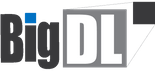

# Vision Transformer Examples for InferenceOptimizer

## step 0 : Prepare Dataset

As InferenceOptimizer needs validation data to calculate accuracy metric, we need to download [ImageNet validation dataset](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar) and [development kit](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz), and place them under directory `./img_data`.


In [2]:
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader, Subset
import torch
import numpy as np

def create_imagenet_val_dataset(limit_num_samples=None):
    dataset = ImageNet(root="img_data", split="val")
    if limit_num_samples is not None:
        indices = np.random.permutation(len(dataset))[:limit_num_samples]
        dataset = Subset(dataset, indices)
    return dataset

## step 1 : Import related package

In [3]:
from bigdl.nano.pytorch import InferenceOptimizer
import timm
from torchmetrics import Accuracy
import time

2022-09-06 16:04:21.133763: I tensorflow/core/util/util.cc:159] Experimental oneDNN custom operations are on. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-06 16:04:21.137674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 16:04:21.137687: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## step 2 : Define model and optimize

### 1. mobilevit

In [3]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=256,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.0, 0.0, 0.0),
                               std=(1.0, 1.0, 1.0))
val_dataloader = create_loader(val_dataset,
                               input_size=256,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.0, 0.0, 0.0),
                               std=(1.0, 1.0, 1.0))
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

In [4]:
model = timm.create_model("mobilevit_xxs", pretrained=True)

optimizer = InferenceOptimizer()
st = time.perf_counter()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   cpu_num=1)
end = time.perf_counter()
print("optimization cost {:.4f}s".format(end-st))
acc_model, option = optimizer.get_best_model()
print("best option is ", option)
print(acc_model(next(iter(val_dataloader))[0]).argmax())

2022-09-06 12:35:46,775 - torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /tmp/tmpged5nexs
2022-09-06 12:35:46,779 - torch.distributed.nn.jit.instantiator - INFO - Writing /tmp/tmpged5nexs/_remote_module_non_scriptable.py
/opt/anaconda3/envs/nano/lib/python3.7/site-packages/intel_extension_for_pytorch/frontend.py:262: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
2022-09-06 12:35:58,398 - bigdl.nano.utils.log4Error - ERROR - 

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
2022-09-06 12:35:58,401 - bigdl.nano.utils.log4Error - ERROR - 

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
2022-09-06 12:35:58,402 - bigdl.nano.utils.log4Error - ERROR - 

****************************Call Stack**************

[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmph8bivt4w/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmph8bivt4w/tmp.bin
[ SUCCESS ] Total execution time: 0.71 seconds. 
[ SUCCESS ] Memory consumed: 119 MB. 


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmp8djui2ig/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmp8djui2ig/tmp.bin
[ SUCCESS ] Total execution time: 0.71 seconds. 
[ SUCCESS ] Memory consumed: 119 MB. 
('{} cannot be pickled', '_MultiProcessingDataLoaderIter')
('{} cannot be pickled', '_MultiProcessingDataLoaderIter')
==========================Optimization Results==========================
accleration option: original, latency: 33.2929ms, accuracy : 0.6719
accleration option: fp32_ipex, latency: 37.0083ms, accuracy : 0.6719
accleration option: bf16_ipex, latency: 210.7912ms, accuracy : 0.6781
accleration option: int8, latency: 35.7670ms, accuracy : 0.0031
accleration option: jit_fp32, latency: 20.0340ms, accuracy : 0.6719
accleration option: jit_fp32_ipex, latency: 19.7864ms, accuracy : 0.6719
accleration option: jit_fp32_ipex_clast, latency: 15.4676ms, accuracy : 0.6719
accleration option: openvino_fp32, latency: 10.9643ms, accuracy : 0.6719
accleration option: o

### 2. poolformer

In [5]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225))
val_dataloader = create_loader(val_dataset,
                               input_size=224,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225))
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

In [6]:
model = timm.create_model("poolformer_s12", pretrained=True)

optimizer = InferenceOptimizer()
st = time.perf_counter()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   cpu_num=1)
end = time.perf_counter()
print("optimization cost {:.4f}s".format(end-st))
acc_model, option = optimizer.get_best_model()
print("best option is ", option)
print(acc_model(next(iter(val_dataloader))[0]).argmax())

2022-09-06 12:40:16 [ERROR] 

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
[ ERROR ]  

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
2022-09-06 12:40:16 [ERROR] 

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
[ ERROR ]  

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
2022-09-06 12:40:16 [ERROR] 

****************************Call Stack*************************
[ ERROR ]  

****************************Call Stack*************************
2022-09-06 12:41:00 [ERROR] Unexpected exception AttributeError("'GraphModule' object has no attribute 'network.0.0.layer_scale_1'") happened during tuning.
[ ERROR ]  Unexpected exception AttributeError("'GraphModule' object has no attribut

Found no quantized model satisfying accuracy criterion.


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmp562kdxjy/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmp562kdxjy/tmp.bin
[ SUCCESS ] Total execution time: 0.71 seconds. 
[ SUCCESS ] Memory consumed: 176 MB. 


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpsjbjl_vl/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmpsjbjl_vl/tmp.bin
[ SUCCESS ] Total execution time: 0.74 seconds. 
[ SUCCESS ] Memory consumed: 177 MB. 
('{} cannot be pickled', '_MultiProcessingDataLoaderIter')
('{} cannot be pickled', '_MultiProcessingDataLoaderIter')
==========================Optimization Results==========================
accleration option: original, latency: 58.6403ms, accuracy : 0.7469
accleration option: fp32_ipex, latency: 65.9670ms, accuracy : 0.7469
accleration option: bf16_ipex, latency: 746.6169ms, accuracy : 0.7469
accleration option: jit_fp32, latency: 60.0695ms, accuracy : 0.7469
accleration option: jit_fp32_ipex, latency: 53.1404ms, accuracy : 0.7469
accleration option: jit_fp32_ipex_clast, latency: 54.2720ms, accuracy : 0.7469
accleration option: openvino_fp32, latency: 24.3597ms, accuracy : 0.7469
accleration option: openvino_int8, latency: 14.7782ms, accuracy : 0.7344
accleration 

### 3. swin

In [9]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225))
val_dataloader = create_loader(val_dataset,
                               input_size=224,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225))
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

In [10]:
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)

optimizer = InferenceOptimizer()
st = time.perf_counter()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   cpu_num=1)
end = time.perf_counter()
print("optimization cost {:.4f}s".format(end-st))
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
print(acc_model(next(iter(val_dataloader))[0]).argmax())

2022-09-06 17:17:55 [ERROR] 

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
[ ERROR ]  

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
2022-09-06 17:17:55 [ERROR] 

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
[ ERROR ]  

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
2022-09-06 17:17:55 [ERROR] 

****************************Call Stack*************************
[ ERROR ]  

****************************Call Stack*************************
[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpnb4793_5/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmpnb4793_5/tmp.bin
[ SUCCESS ] Total execution time: 4.85 seconds. 
[ SUCCESS ] Memory consumed: 800 MB. 


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmp8xdvlkgn/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmp8xdvlkgn/tmp.bin
[ SUCCESS ] Total execution time: 4.80 seconds. 
[ SUCCESS ] Memory consumed: 801 MB. 
('{} cannot be pickled', '_MultiProcessingDataLoaderIter')
('{} cannot be pickled', '_MultiProcessingDataLoaderIter')
==========================Optimization Results==========================
accleration option: original, latency: 411.2000ms, accuracy : 0.8625
accleration option: fp32_ipex, latency: 397.5534ms, accuracy : 0.8625
accleration option: bf16_ipex, latency: 2133.6425ms, accuracy : 0.8625
accleration option: int8, latency: 224.6975ms, accuracy : 0.8594
accleration option: jit_fp32, latency: 317.4087ms, accuracy : 0.0000
accleration option: jit_fp32_ipex, latency: 320.1967ms, accuracy : 0.0000
accleration option: jit_fp32_ipex_clast, latency: 314.8059ms, accuracy : 0.0000
accleration option: openvino_fp32, latency: 178.8095ms, accuracy : 0.0000
accleration o